<a href="https://colab.research.google.com/github/HEM2058/sentinelhub_remote_sensing/blob/main/NDVI_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sentinelhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.4/245.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.4 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6084 sha256=67b5f4b47be289c85f98fe08c7d6075ef29471081a111ae3c489d68572da83dd
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [ ]:

# This is script may only work with sentinelhub.__version__ >= '3.4.0'
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig, Geometry

# Credentials
config = SHConfig()
config.sh_client_id = '80cb4233-97cd-4ae8-aa82-787cc091082f'
config.sh_client_secret = 'Oh48OTexSh32T4InF8fBje5BGvnAYH6i'

# Evalscript
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"], // Red and NIR bands
    output: { bands: 1,
    sampleType: "FLOAT32"  } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);

  // Return NDVI value
  return [ndvi];
}
"""

# Define bounding box
bbox = BBox(bbox= [
  83.876,
  28.156,
  84.032,
  28.312
], crs=CRS.WGS84)

# Create SentinelHub request with TIFF format and FLOAT32 sample type
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2023-11-24', '2024-01-24'),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
    ],
    bbox=bbox,
    size=[512, 354.253],
    config=config,

)


# Get data from the request
response = request.get_data()


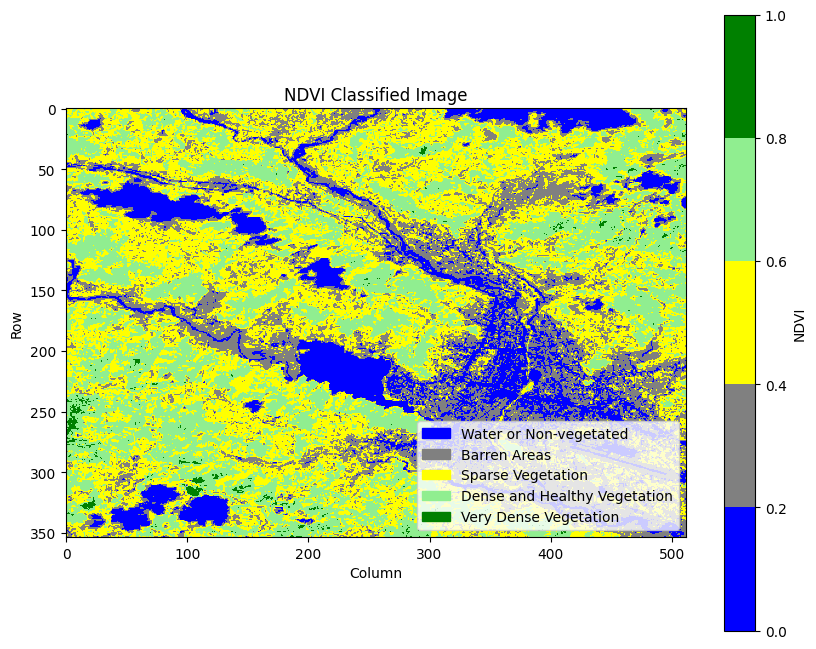

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import numpy as np

# Sample NDVI image data
ndvi_image = response[0]  # Assuming response[0] contains the NDVI data in matrix format

# Define the NDVI classification thresholds and corresponding labels
thresholds = [0, 0.3, 0.6, 0.9, 1]
labels = ['Water or Non-vegetated', 'Barren Areas', 'Sparse Vegetation', 'Dense and Healthy Vegetation', 'Very Dense Vegetation']

# Define colors for each class
colors = ['blue', 'gray', 'yellow', 'lightgreen', 'green']

# Create a colormap based on the defined colors
cmap = ListedColormap(colors)

# Normalize the NDVI values to the range [0, 1]
norm = Normalize(vmin=0, vmax=1)

# Plot the NDVI image with colormap
plt.figure(figsize=(10, 8))
plt.imshow(ndvi_image, cmap=cmap, norm=norm)
plt.colorbar(label='NDVI')
plt.title('NDVI Classified Image')
plt.xlabel('Column')
plt.ylabel('Row')

# Create legend
legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=legend_handles, loc='lower right')

plt.show()


In [70]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig, Geometry
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape, mapping
import json
from rasterio.features import shapes

# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'

# Evalscript to calculate NDVI
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"], // Red and NIR bands
    output: { bands: 1,
    sampleType: "FLOAT32"  } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);

  // Return NDVI value
  return [ndvi];
}
"""

# Define bounding box
bbox = BBox(bbox=[83.93433379460498, 28.24635600957282, 83.93568176542095, 28.247151041120986], crs=CRS.WGS84)

# Create SentinelHub request
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2023-11-24', '2024-01-24'),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
    ],
    bbox=bbox,
    size=[512, 354.253],
    config=config,
)

# Fetch data from the request
response = request.get_data()
response_data = response[0]

# Define geospatial information
transform = rasterio.transform.from_bounds(bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y, response_data.shape[1], response_data.shape[0])

# Load GeoJSON polygon for clipping
geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
        [
            [83.93433379460498, 28.246840164244404],
            [83.9343511504502, 28.24673823715638],
            [83.93443792967332, 28.24672804444276],
            [83.93447842664358, 28.24671785172758],
            [83.93452470889645, 28.246671984497468],
            [83.93462305868212, 28.246646502694574],
            [83.9348024026259, 28.246524189817478],
            [83.93505116973273, 28.246498707979256],
            [83.93521315761637, 28.246478322504615],
            [83.9352825809944, 28.246463033395955],
            [83.935513992256, 28.24635600957282],
            [83.93560655676174, 28.246412069683643],
            [83.93568176542095, 28.24655476801567],
            [83.93561812732423, 28.2467127552312],
            [83.93562969788684, 28.246784104219913],
            [83.93555448922757, 28.24693189840154],
            [83.93547349528575, 28.246987958209644],
            [83.93537514549877, 28.24700834358744],
            [83.93526522515054, 28.247079692378378],
            [83.93514373423704, 28.24710007773801],
            [83.93498174635471, 28.247151041120986],
            [83.93470405284023, 28.247140848446207],
            [83.93440900348185, 28.24704911433072],
            [83.93433379460498, 28.246840164244404]
        ]
    ]
}

polygon = shape(geojson_polygon)

# Clip the georeferenced TIFF file using the polygon
with rasterio.io.MemoryFile() as memfile:
    with memfile.open(driver='GTiff', width=response_data.shape[1], height=response_data.shape[0],
                      count=1, dtype=response_data.dtype, crs=str(bbox.crs), transform=transform) as dataset:
        dataset.write(response_data, 1)

        out_image, out_transform = mask(dataset, [mapping(polygon)], crop=True)
        out_meta = dataset.meta.copy()

out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Reclassify the raster data based on NDVI values
def reclassify_ndvi(ndvi_array):
    print(ndvi_array)
    classified_array = np.zeros_like(ndvi_array, dtype=np.uint8)
    classified_array[(ndvi_array <= 0)] = 1  # Water or Non-vegetated
    classified_array[(ndvi_array > 0) & (ndvi_array <= 0.1)] = 1  # Barren Areas
    classified_array[(ndvi_array > 0.1) & (ndvi_array <= 0.2)] = 2  # Sparse Vegetation
    classified_array[(ndvi_array > 0.2) & (ndvi_array <= 0.4)] = 3  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.4) & (ndvi_array <= 0.5)] = 4  # Very Dense Vegetation
    classified_array[(ndvi_array > 0.5) & (ndvi_array <= 0.6)] =  5  # Sparse Vegetation
    classified_array[(ndvi_array > 0.6) & (ndvi_array <= 0.65)] = 6  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.65) & (ndvi_array <= 0.7)] = 7
    return classified_array

classified_image = reclassify_ndvi(out_image[0])

# Convert the classified raster to vector GeoJSON
shapes_gen = shapes(classified_image, mask=None, transform=out_transform)
geometries = list(shapes_gen)

labels = ['Water or Non-vegetated', 'Barren Areas', 'Sparse Vegetation', 'Dense and Healthy Vegetation', 'Very Dense Vegetation']

features = []
for geom, value in geometries:
    if value != 0:  # Skip no-data values
        features.append({
            "type": "Feature",
            "geometry": geom,
            "properties": {
                "class_no": value  # Assign value to a property named "label" (or any desired name)
            }  # Convert value to label
        })

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

with open('classified_vector_map.geojson', 'w') as f:
    json.dump(geojson_data, f)

print("Classified vector GeoJSON map saved.")


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Classified vector GeoJSON map saved.
